## Task 1: Extract Insights from Data

In [128]:
import pandas as pd
import json
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict
from wordcloud import WordCloud

In [106]:
data_name = Path('Oppositional_thinking_analysis_dataset')
data_path = Path('data_ota') / data_name.with_suffix(".json")
assert data_path.exists, "File doesn't exist!"

In [107]:
# read file
with open(data_path, 'r', encoding='utf-8') as file:
    data = json.load(file)
df = pd.json_normalize(data)

In [108]:
# add text length column
df['text_length'] = df['text'].apply(len)
# add number of unique column
df['unique_words'] = df['text'].apply(lambda x: len(set(x.split())))
display(df.head())

,id,text,category,annotations,spacy_tokens,text_length,unique_words
0,5206,THIS IS MASSIVE Australian Senator Malcolm Rob...,CONSPIRACY,[{'span_text': 'Australian Senator Malcolm Rob...,WyJUSElTIiwgIklTIiwgIk1BU1NJVkUiLCAiQXVzdHJhbG...,218,37
1,1387,“ I ’m deeply concerned that the push to vacci...,CRITICAL,[{'span_text': 'I ’m deeply concerned that the...,WyJcdTIwMWMiLCAiSSIsICJcdTIwMTltIiwgImRlZXBseS...,294,48
2,13116,2021 : They wanted to know your vaccination st...,CRITICAL,"[{'span_text': 'someone who died suddenly', 'c...",WyIyMDIxIiwgIjoiLCAiVGhleSIsICJ3YW50ZWQiLCAidG...,198,28
3,11439,Anthony Fauci once again defended brutal Chine...,CRITICAL,"[{'span_text': 'brutal Chinese lockdowns', 'ca...",WyJBbnRob255IiwgIkZhdWNpIiwgIm9uY2UiLCAiYWdhaW...,326,47
4,98,Proof has emerged showing that death from Wuha...,CRITICAL,[{'span_text': 'death from Wuhan coronavirus (...,WyJQcm9vZiIsICJoYXMiLCAiZW1lcmdlZCIsICJzaG93aW...,698,105


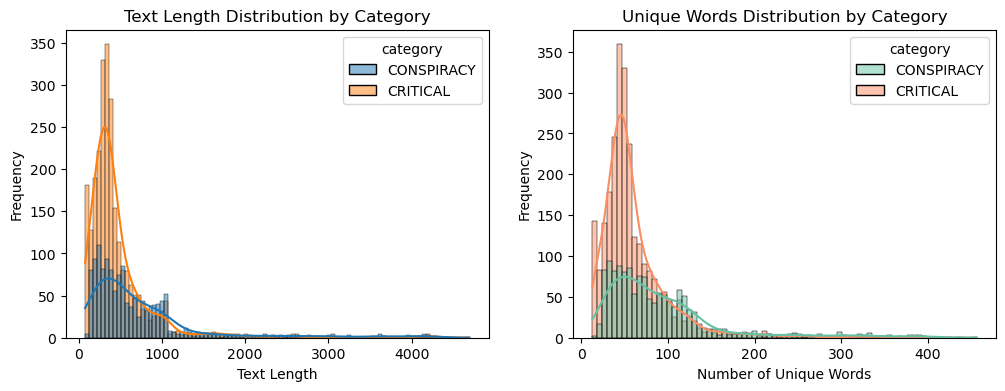

In [109]:
# Plot text length distribution
plt.figure(figsize=(12, 4))
plt.subplot(1,2,1)
sns.histplot(data=df, x='text_length', hue='category', kde=True)
plt.title('Text Length Distribution by Category')
plt.xlabel('Text Length')
plt.ylabel('Frequency')

plt.subplot(1,2,2)
sns.histplot(data=df, x='unique_words', hue='category', kde=True, palette='Set2')
plt.title('Unique Words Distribution by Category')
plt.xlabel('Number of Unique Words')
plt.ylabel('Frequency')

plt.show()

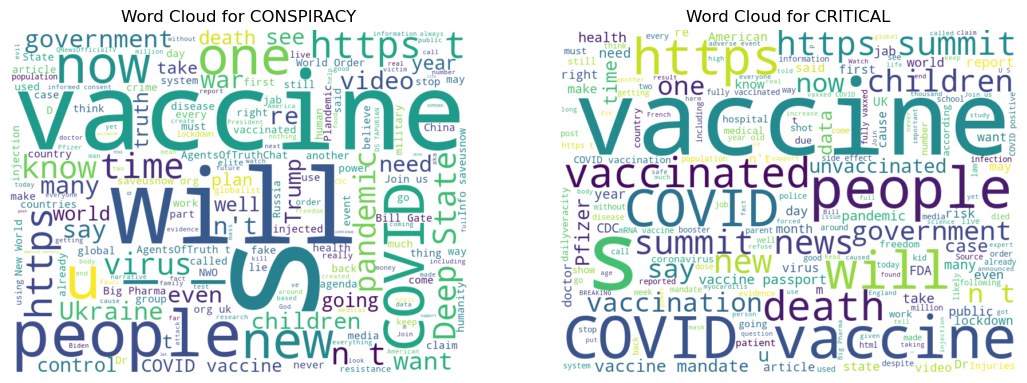

In [110]:
# Word Cloud for each category
plt.figure(figsize=(13, 8))
for category, i in zip(df['category'].unique(), range(2)):
    text = " ".join(df[df['category'] == category]['text'])
    wordcloud = WordCloud(width=800, height=600, background_color='white').generate(text)
    plt.subplot(1, 2, i+1)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud for {category}')
    plt.axis('off')
plt.show()

In [111]:
# extract information of annotations and tokens
annotations_expanded = df.explode('annotations')[['id', 'annotations']]
annotations_df = pd.json_normalize(annotations_expanded['annotations'])
annotations_df['id'] = annotations_expanded['id'].values
annotations_df.head()

,span_text,category,annotator,start_char,end_char,start_spacy_token,end_spacy_token,id
0,Australian Senator Malcolm Roberts,CAMPAIGNER,gold_label,16,50,3,7,5206
1,the first politician,CAMPAIGNER,gold_label,135,155,24,27,5206
2,I ’m deeply concerned that the push to vaccina...,NEGATIVE_EFFECT,gold_label,2,135,1,22,1387
3,to vaccinate these children,OBJECTIVE,gold_label,38,65,8,12,1387
4,these children,VICTIM,gold_label,51,65,10,12,1387


In [112]:
# 统计每个category的出现次数
category_counts = annotations_df['category'].value_counts().reset_index()
category_counts.columns = ['category', 'count']
print(category_counts)

          category  count
0       CAMPAIGNER   5096
1            AGENT   5082
2  NEGATIVE_EFFECT   4387
3           VICTIM   3517
4      FACILITATOR   2763
5        OBJECTIVE   1602
6                X    206


In [113]:
# 合并标注信息到原始数据
df = df.merge(annotations_df.groupby('id')['category'].apply(list).reset_index(), on='id', how='left', suffixes=('', '_annotations'))
df.head()

,id,text,category,annotations,spacy_tokens,text_length,unique_words,category_annotations
0,5206,THIS IS MASSIVE Australian Senator Malcolm Rob...,CONSPIRACY,[{'span_text': 'Australian Senator Malcolm Rob...,WyJUSElTIiwgIklTIiwgIk1BU1NJVkUiLCAiQXVzdHJhbG...,218,37,"[CAMPAIGNER, CAMPAIGNER]"
1,1387,“ I ’m deeply concerned that the push to vacci...,CRITICAL,[{'span_text': 'I ’m deeply concerned that the...,WyJcdTIwMWMiLCAiSSIsICJcdTIwMTltIiwgImRlZXBseS...,294,48,"[NEGATIVE_EFFECT, OBJECTIVE, VICTIM, CAMPAIGNE..."
2,13116,2021 : They wanted to know your vaccination st...,CRITICAL,"[{'span_text': 'someone who died suddenly', 'c...",WyIyMDIxIiwgIjoiLCAiVGhleSIsICJ3YW50ZWQiLCAidG...,198,28,"[VICTIM, NEGATIVE_EFFECT]"
3,11439,Anthony Fauci once again defended brutal Chine...,CRITICAL,"[{'span_text': 'brutal Chinese lockdowns', 'ca...",WyJBbnRob255IiwgIkZhdWNpIiwgIm9uY2UiLCAiYWdhaW...,326,47,"[NEGATIVE_EFFECT, AGENT, NEGATIVE_EFFECT]"
4,98,Proof has emerged showing that death from Wuha...,CRITICAL,[{'span_text': 'death from Wuhan coronavirus (...,WyJQcm9vZiIsICJoYXMiLCAiZW1lcmdlZCIsICJzaG93aW...,698,105,"[NEGATIVE_EFFECT, CAMPAIGNER, NEGATIVE_EFFECT,..."


## Task 2: Pre-processing

In [119]:
from nltk.stem import PorterStemmer
import nltk
from nltk.corpus import stopwords
import re
from tqdm import tqdm
import time
import base64

In [120]:
def download_with_progress(resource):
    print(f"Downloading {resource}...")
    for _ in tqdm(range(100), desc=f"Downloading {resource}", unit="B", unit_scale=True, ncols=100):
        time.sleep(0.01)
    nltk.download(resource)

download_with_progress('stopwords')
stop_words = set(stopwords.words('english'))

stemmer = PorterStemmer() # initialize nltk stemmer

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\siyux\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [121]:
def decode_tokens(tokens):
    """
    decode spaCy tokens from base64
    """
    decoded_bytes = base64.b64decode(tokens)
    decoded_str = decoded_bytes.decode('utf-8')
    return json.loads(decoded_str)

def preprocess_stpw(tokens):
    """
    normalization: remove punctuation and stop words
    """
    tokens = [token.lower() for token in tokens if token.isalnum() and token not in stop_words]
    return ' '.join(tokens)

def preprocess_stpw_stem(tokens):
    tokens = [stemmer.stem(token.lower()) for token in tokens if token.isalnum() and token not in stop_words]
    return ' '.join(tokens)

In [122]:
# 解码和预处理 spacy tokens
df['decoded_tokens'] = df['spacy_tokens'].apply(decode_tokens)
df['process_stpw_stem'] = df['decoded_tokens'].apply(preprocess_stpw_stem)
df['process_stpw'] = df['decoded_tokens'].apply(preprocess_stpw)

In [123]:
df.head()

,id,text,category,annotations,spacy_tokens,text_length,unique_words,category_annotations,decoded_tokens,process_stpw_stem,process_stpw
0,5206,THIS IS MASSIVE Australian Senator Malcolm Rob...,CONSPIRACY,[{'span_text': 'Australian Senator Malcolm Rob...,WyJUSElTIiwgIklTIiwgIk1BU1NJVkUiLCAiQXVzdHJhbG...,218,37,"[CAMPAIGNER, CAMPAIGNER]","[THIS, IS, MASSIVE, Australian, Senator, Malco...",thi is massiv australian senat malcolm robert ...,this is massive australian senator malcolm rob...
1,1387,“ I ’m deeply concerned that the push to vacci...,CRITICAL,[{'span_text': 'I ’m deeply concerned that the...,WyJcdTIwMWMiLCAiSSIsICJcdTIwMTltIiwgImRlZXBseS...,294,48,"[NEGATIVE_EFFECT, OBJECTIVE, VICTIM, CAMPAIGNE...","[“, I, ’m, deeply, concerned, that, the, push,...",i deepli concern push vaccin children noth dys...,i deeply concerned push vaccinate children not...
2,13116,2021 : They wanted to know your vaccination st...,CRITICAL,"[{'span_text': 'someone who died suddenly', 'c...",WyIyMDIxIiwgIjoiLCAiVGhleSIsICJ3YW50ZWQiLCAidG...,198,28,"[VICTIM, NEGATIVE_EFFECT]","[2021, :, They, wanted, to, know, your, vaccin...",2021 they want know vaccin statu see paper all...,2021 they wanted know vaccination status see p...
3,11439,Anthony Fauci once again defended brutal Chine...,CRITICAL,"[{'span_text': 'brutal Chinese lockdowns', 'ca...",WyJBbnRob255IiwgIkZhdWNpIiwgIm9uY2UiLCAiYWdhaW...,326,47,"[NEGATIVE_EFFECT, AGENT, NEGATIVE_EFFECT]","[Anthony, Fauci, once, again, defended, brutal...",anthoni fauci defend brutal chines lockdown ad...,anthony fauci defended brutal chinese lockdown...
4,98,Proof has emerged showing that death from Wuha...,CRITICAL,[{'span_text': 'death from Wuhan coronavirus (...,WyJQcm9vZiIsICJoYXMiLCAiZW1lcmdlZCIsICJzaG93aW...,698,105,"[NEGATIVE_EFFECT, CAMPAIGNER, NEGATIVE_EFFECT,...","[Proof, has, emerged, showing, that, death, fr...",proof emerg show death wuhan coronaviru covid ...,proof emerged showing death wuhan coronavirus ...


## Task 3: Text classification

In [15]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from scipy.sparse import hstack

In [27]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
import numpy as np
import tensorflow as tf

### Sub-task 1
* Split data into train and test sets. Use 20% of the data as the test set. Make sure to under or
over-sample in case of imbalance in classes.
* Train a naïve Bayes model on the training part and test it, using the test set.
    * Compare the impact of different vectorization models (e.g., count vectorizer, TF-IDF,
    and …) on the final performance of your naïve Bayes model.
    * Compare the impact of different pre-processing pipelines (e.g., with and without stop
    words, stemming, and …) on the final performance of your naïve Bayes model.
    * Perform error analysis on the model’s prediction. In other words, analyze errors that
    have been made by the model and describe why your model couldn’t work well in
    case of these errors.

In [56]:
class ModelComparison:
    
    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.X_train, self.X_test, self.y_train, self.y_test, self.y_pred = None, None, None, None, None
        self.history = None
        self.evaluation = {
            'model': [],
            'vectorizer': [],
            'accuracy': []
        }
        self.accuracy = None
        self.model = None

    def set_X(self, X):
        self.X = X
        
    def set_vectorizer(self, vectorizer):
        """
        Vectorize the text or text&annotations into feature vectors.
        """
        if vectorizer == 'bow':
            return CountVectorizer()
        elif vectorizer == 'tfidf':
            return TfidfVectorizer()

    def set_model(self, model):
        self.model = model
        if model == 'fnn':
            self.y = to_categorical(pd.factorize(df['category'])[0])
            
    def predict(self, vectorizer='bow', model='nb'):
        V = self.set_vectorizer(vectorizer)
        X_vectorized = V.fit_transform(self.X)
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X_vectorized, self.y, test_size=0.2, random_state=42)
        
        if self.model == 'nb':
            M = MultinomialNB()
            M.fit(self.X_train, self.y_train)
            self.y_pred = M.predict(self.X_test)
            self.evaluation_nb()
            
        elif model == 'fnn':
            input_dim = self.X_train.shape[1]
            output_dim = len(np.unique(self.y))
            self.fit_fnn(input_dim, output_dim)
            self.evaluation_fnn()
        self.update_eval(vectorizer, model)
    
    def fit_fnn(self, input_dim, output_dim):
        model = Sequential()
        model.add(Dense(128, input_dim=input_dim, activation='relu'))
        model.add(Dropout(0.5))
        model.add(Dense(64, activation='relu'))
        model.add(Dense(output_dim, activation='softmax'))

        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', ModelComparison.f1_score])

        self.history = model.fit(self.X_train.toarray(), self.y_train, epochs=7, batch_size=32, verbose=1)
        self.y_pred = np.argmax(model.predict(self.X_test.toarray()), axis=1)
        self.accuracy = max(self.history.history['accuracy'])
    
    def evaluation_nb(self):
        accuracy = accuracy_score(self.y_test, self.y_pred)
        self.accuracy = accuracy
        report = classification_report(self.y_test, self.y_pred, output_dict=True)
        confusion = confusion_matrix(self.y_test, self.y_pred)

        report_df = pd.DataFrame(report).transpose().iloc[:2]
        confusion = confusion[:2, :2]
        print(f"Accuracy: {accuracy:.4f}\n")
        print("Classification Report:\n", report_df)

        plt.figure(figsize=(6, 3.5))
        plt.subplot(1,2,1)
        sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues")
        plt.title('clf')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')

        plt.subplot(1, 2, 2)
        report_df.drop(['support'], axis=1, inplace=True)
        report_df.plot(kind='bar', ax=plt.gca())
        plt.title('clf')
        plt.xlabel('Classes')
        plt.ylabel('Scores')
        plt.legend(loc='lower right')
        
        plt.tight_layout()
        plt.show()
        
    def evaluation_fnn(self):
        plt.figure(figsize=(5, 3))
        # 设置颜色和标签
        metrics = ['accuracy', 'loss', 'f1_score']
        colors = ['purple', 'gray', 'orange']
        labels = ['Accuracy', 'Loss', 'F1 Score']
        
        for metric, color, label in zip(metrics, colors, labels):
            plt.plot(self.history.history[metric], color=color, label=label)
            plt.fill_between(range(len(self.history.history[metric])), 
                             self.history.history[metric], color=color, alpha=0.1)
        
        plt.xlabel('Epochs')
        plt.ylabel('Value')
        plt.title('Metrics over Epochs')
        plt.legend()
        plt.show()
        
    def update_eval(self, vectorizer, model):
        self.evaluation['model'].append(model)
        self.evaluation['vectorizer'].append(vectorizer)
        self.evaluation['accuracy'].append(self.accuracy)
        

    @staticmethod
    def f1_score(y_true, y_pred):
        y_pred = tf.argmax(y_pred, axis=1)
        y_true = tf.argmax(y_true, axis=1)
        precision = tf.reduce_sum(tf.cast(y_true * y_pred, tf.float32)) / (tf.reduce_sum(tf.cast(y_pred, tf.float32)) + tf.keras.backend.epsilon())
        recall = tf.reduce_sum(tf.cast(y_true * y_pred, tf.float32)) / (tf.reduce_sum(tf.cast(y_true, tf.float32)) + tf.keras.backend.epsilon())
        return 2 * (precision * recall) / (precision + recall + tf.keras.backend.epsilon())

In [57]:
MC = ModelComparison(df['process_stpw'], df['category'])
MC.set_model('nb')

Accuracy: 0.8612

Classification Report:
             precision    recall  f1-score  support
CONSPIRACY   0.770115  0.797619  0.783626    252.0
CRITICAL     0.905380  0.890511  0.897884    548.0


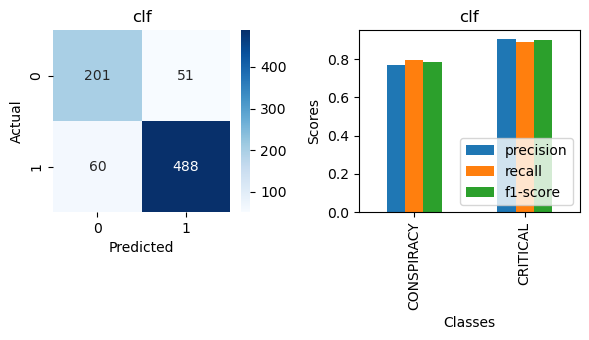

In [58]:
"""
| Nr. | preprocessing | vectorizer | model |
|  01 |  stop words   |    BoW     |  NB   |
"""
MC.predict()

Accuracy: 0.8187

Classification Report:
             precision   recall  f1-score  support
CONSPIRACY   0.981982  0.43254  0.600551    252.0
CRITICAL     0.792453  0.99635  0.882781    548.0


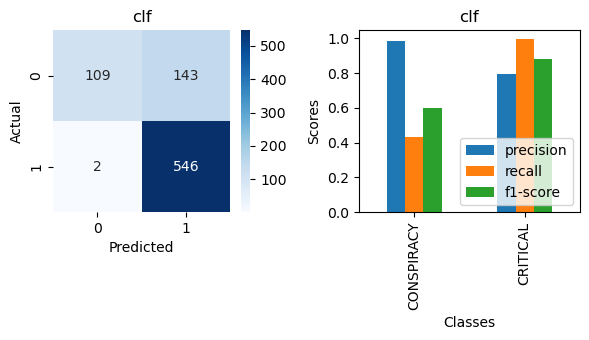

In [59]:
"""
| Nr. | preprocessing | vectorizer | model |
|  02 |  stop words   |    TFI-DF  |  NB   |
"""
MC.predict('tfidf', 'nb')

Accuracy: 0.8638

Classification Report:
             precision    recall  f1-score  support
CONSPIRACY   0.773946  0.801587  0.787524    252.0
CRITICAL     0.907236  0.892336  0.899724    548.0


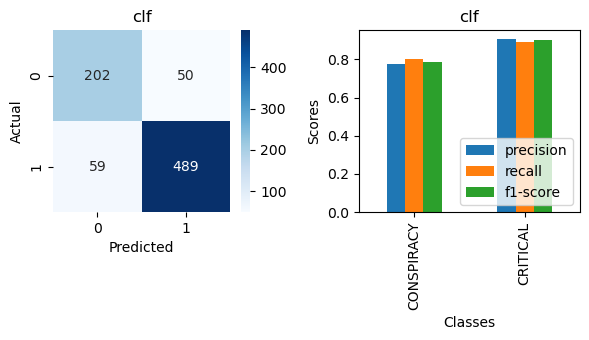

In [60]:
"""
| Nr. | preprocessing           | vectorizer | model |
|  04 |  stop words & stemming  |    BoW     |  NB   |
"""
MC.set_X(df['process_stpw_stem'])
MC.predict('bow', 'nb')

Accuracy: 0.8275

Classification Report:
             precision    recall  f1-score  support
CONSPIRACY   0.959677  0.472222  0.632979    252.0
CRITICAL     0.803254  0.990876  0.887255    548.0


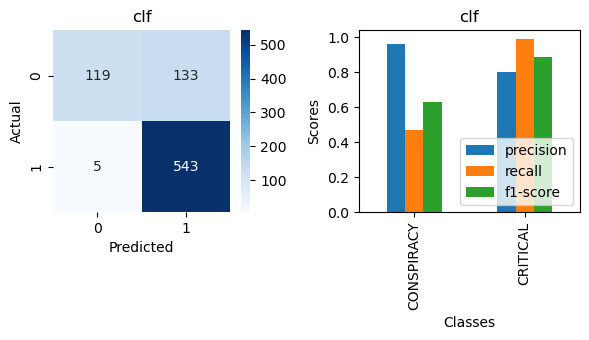

In [61]:
"""
| Nr. | preprocessing           | vectorizer | model |
|  04 |  stop words & stemming  |    TFI-DF  |  NB   |
"""
MC.predict('tfidf', 'nb')

In [62]:
MC.evaluation

{'model': ['nb', 'nb', 'nb', 'nb'],
 'vectorizer': ['bow', 'tfidf', 'bow', 'tfidf'],
 'accuracy': [0.86125, 0.81875, 0.86375, 0.8275]}

### Sub-task 2
* Train a feed-forward neural network model and report its performance (F1 score) on test data.
    * Again, compare the impact of different vectorization approaches on the final
    performance of your model.
    * Again, Compare the impact of different pre-processing pipelines (e.g., with and
    without stop words, stemming, and …) on the final performance of your model.
    * Perform error analysis on the model’s prediction.

In [42]:
y = pd.factorize(df['category'])[0]
y_categorical = to_categorical(y)
MC = ModelComparison(df['process_stpw'], y_categorical)

C:\Users\siyux\.conda\envs\mydata\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/7
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - accuracy: 0.7309 - f1_score: 0.7853 - loss: 0.5604
Epoch 2/7
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9310 - f1_score: 0.9446 - loss: 0.1980
Epoch 3/7
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.9785 - f1_score: 0.9835 - loss: 0.0681
Epoch 4/7
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 0.9938 - f1_score: 0.9950 - loss: 0.0286
Epoch 5/7
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 0.9967 - f1_score: 0.9976 - loss: 0.0136
Epoch 6/7
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.9989 - f1_score: 0.9992 - loss: 0.0084
Epoch 7/7
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9994 - f1_score: 0.9995 - loss: 0.0038
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


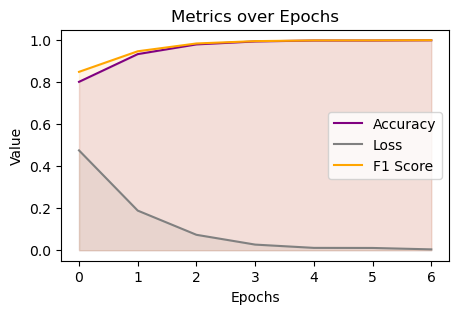

In [69]:
"""
| Nr. | preprocessing | vectorizer | model |
|  05 |  stop words   |    BoW     |  FNN  |
"""
MC.set_model('fnn')
MC.set_X(df['process_stpw'])
MC.predict('bow', 'fnn')

Epoch 1/7
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - accuracy: 0.6511 - f1_score: 0.7707 - loss: 0.6216
Epoch 2/7
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - accuracy: 0.9272 - f1_score: 0.9428 - loss: 0.2129
Epoch 3/7
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - accuracy: 0.9751 - f1_score: 0.9800 - loss: 0.0711
Epoch 4/7
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.9954 - f1_score: 0.9965 - loss: 0.0195
Epoch 5/7
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 0.9985 - f1_score: 0.9989 - loss: 0.0083
Epoch 6/7
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9994 - f1_score: 0.9995 - loss: 0.0052
Epoch 7/7
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - accuracy: 0.9993 - f1_score: 0.9994 - loss: 0.0047
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


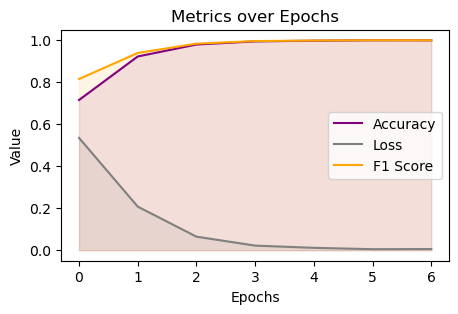

In [70]:
"""
| Nr. | preprocessing | vectorizer | model |
|  06 |  stop words   |    TFI-DF  |  FNN  |
"""
MC.predict('tfidf', 'fnn')

Epoch 1/7
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.7190 - f1_score: 0.7392 - loss: 0.5560
Epoch 2/7
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.9325 - f1_score: 0.9446 - loss: 0.2241
Epoch 3/7
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.9700 - f1_score: 0.9759 - loss: 0.0913
Epoch 4/7
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.9914 - f1_score: 0.9929 - loss: 0.0467
Epoch 5/7
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.9968 - f1_score: 0.9975 - loss: 0.0197
Epoch 6/7
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.9982 - f1_score: 0.9985 - loss: 0.0102
Epoch 7/7
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.9963 - f1_score: 0.9972 - loss: 0.0229
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


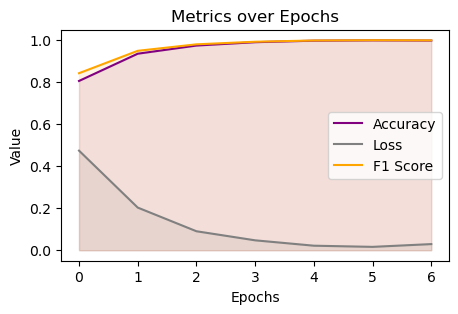

In [71]:
"""
| Nr. | preprocessing           | vectorizer | model |
|  07 |  stop words & stemming  |    BoW     |  FNN  |
"""
MC.set_X(df['process_stpw_stem'])
MC.predict('bow', 'fnn')

Epoch 1/7
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.6765 - f1_score: 0.7841 - loss: 0.6106
Epoch 2/7
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.9306 - f1_score: 0.9453 - loss: 0.1873
Epoch 3/7
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.9820 - f1_score: 0.9857 - loss: 0.0757
Epoch 4/7
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.9920 - f1_score: 0.9940 - loss: 0.0314
Epoch 5/7
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.9977 - f1_score: 0.9983 - loss: 0.0114
Epoch 6/7
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.9992 - f1_score: 0.9995 - loss: 0.0052
Epoch 7/7
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.9989 - f1_score: 0.9992 - loss: 0.0065
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


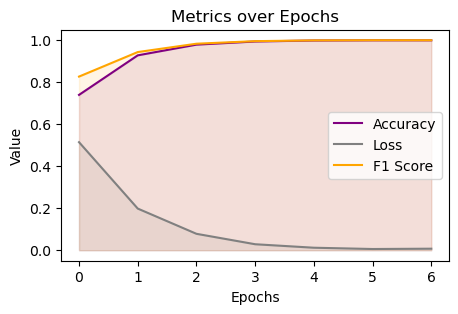

In [72]:
"""
| Nr. | preprocessing           | vectorizer | model |
|  08 |  stop words & stemming  |    TFI-DF  |  FNN  |
"""
MC.predict('tfidf', 'fnn')

### Sub-task 3
* Compare the performance of your naïve Bayes model with the achieved results from the feed-
forward model. What can you conclude from the differences between the performance of the
two models?

,0,1,2,3,4,5,6,7
model,nb,nb,nb,nb,fnn,fnn,fnn,fnn
vectorizer,bow,tfidf,bow,tfidf,bow,tfidf,bow,tfidf
accuracy,0.86125,0.81875,0.86375,0.8275,0.999062,0.999375,0.996875,0.99875
process,stpw,stpw,stpw&stem,stpw&stem,stpw,stpw,stpw&stem,stpw&stem


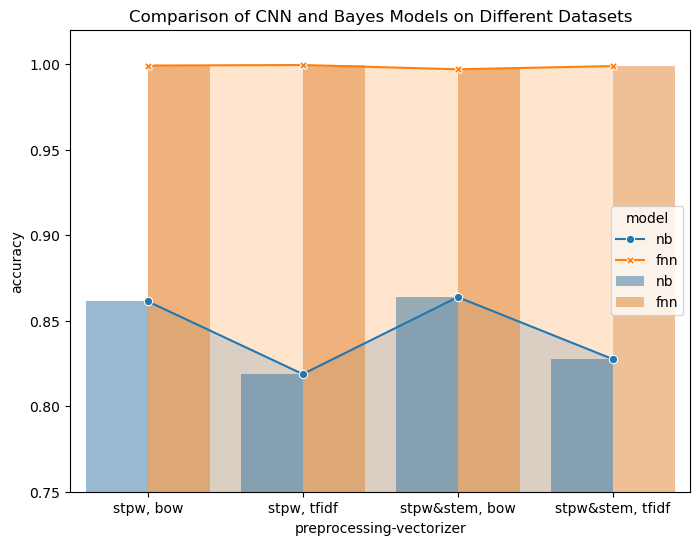

In [102]:
def plot_compar(data):
    df = pd.DataFrame(data)
    plt.figure(figsize=(8,6))
    df['process'] = ['stpw','stpw','stpw&stem','stpw&stem','stpw','stpw','stpw&stem','stpw&stem']
    display(df.transpose())
    df['pv'] = df['process'] + ', ' + df['vectorizer']
    sns.lineplot(x='pv', y='accuracy', hue='model', style='model', data=df, markers=True, dashes=False)
    models = df['model'].unique()
    for model in models:
        subset = df[df['model'] == model]
        plt.fill_between(subset['pv'], subset['accuracy'], alpha=0.2)
    sns.barplot(x='pv', y='accuracy', hue='model', data=df, alpha=0.5)

    plt.ylim(0.75, 1.02)
    
    plt.title('Comparison of CNN and Bayes Models on Different Datasets')
    plt.xlabel('preprocessing-vectorizer')
    plt.ylabel('accuracy')
    
    plt.show()

plot_compar(MC.evaluation)

## Task 4: PMI based word similarity

In [135]:
import random

In [155]:
def cooccurrence_matrix(tokenized_texts, window_size=2):
    cooccu = defaultdict(Counter)
    for text in tokenized_texts:
        for idx, word in enumerate(text):
            start = max(0, idx - window_size)
            end = min(len(text), idx + window_size + 1)
            for idx2 in range(start, end):
                if idx2 != idx:
                    cooccu[word][text[idx2]] += 1
    return cooccu

def pmi_matrix(cooccurrence_matrix, total_words, min_count=2):
    pmi_matrix = defaultdict(dict)
    word_counts = Counter()
    for word, neighbors in cooccurrence_matrix.items():
        word_counts[word] += sum(neighbors.values())
    
    total_count = sum(word_counts.values())
    for word, neighbors in cooccurrence_matrix.items():
        for neighbor, count in neighbors.items():
            if count >= min_count:
                p_w = word_counts[word] / total_count
                p_n = word_counts[neighbor] / total_count
                p_wn = count / total_count
                pmi = np.log2(p_wn / (p_w * p_n))
                if pmi > 0:
                    pmi_matrix[word][neighbor] = pmi
    return pmi_matrix

def most_similar_words(pmi_mat, word, n=5):
    if word in pmi_mat:
        similar_words = sorted(pmi_mat[word].items(), key=lambda x: x[1], reverse=True)[:n]
        return [w for w, _ in similar_words]
    else:
        return [None] * n

In [156]:
df['tokenized_text'] = df['process_stpw_stem'].apply(lambda x: x.split())
cooccu_mat = cooccurrence_matrix(df['tokenized_text'].tolist())

In [157]:
total_words = sum([len(text) for text in df['tokenized_text']])
pmi_mat = pmi_matrix(cooccu_mat, total_words)

In [158]:
random_words = random.sample(list(pmi_mat.keys()), 10)
similar_words = {word: most_similar_words(pmi_mat, word) for word in random_words}

In [159]:
report_df = pd.DataFrame.from_dict(similar_words, orient='index', columns=[f'Similar Word {i+1}' for i in range(5)])
report_df.index.name = 'Random Word'
report_df.reset_index(inplace=True)
report_df

,Random Word,Similar Word 1,Similar Word 2,Similar Word 3,Similar Word 4,Similar Word 5
0,graphic,flyer,imag,resourc,warn,free
1,mccullough,bartlett,peter,cardiologist,richard,dr
2,wen,leana,analyst,None,None,None
3,rather,turnov,helicopt,syncop,mild,overal
4,compil,unwittingli,meta,antenna,list,2021
5,gof,research,None,None,None,None
6,valuabl,degre,insight,elon,commun,medic
7,form,intak,fascism,stabl,fill,adjuv
8,znaju,što,ne,None,None,None
9,amaurot,cat,eye,None,None,None
